In [2]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, StandardScaler


In [4]:
DATA_DIR = "D:/MALLORN-Astronomical-Classification-Challenge/data/raw"
PROCESSED_DIR = "D:/MALLORN-Astronomical-Classification-Challenge/data/processed"

R_LAMBDA = {
    0: 4.81,
    1: 3.64,
    2: 2.70,
    3: 2.06,
    4: 1.58,
    5: 1.31
}

FILTER_MAP = {"u": 0, "g": 1, "r": 2, "i": 3, "z": 4, "y": 5}

def ensure_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
def apply_physics_correction(df, ebv_map):
    """
    De-extiction and log-transform
    """

    # 1. Get information abonut EBV and R_LAMBDA
    df['ebv'] = df['object_id'].map(ebv_map)
    df['filter_id'] = df['Filter'].map(FILTER_MAP)
    df['r_val'] = df['filter_id'].map(R_LAMBDA)

    # Calculate Correction Factor
    # Formulation: Flux_true = Flux_obs * 10^(0.4 * R * EBV)
    correction_factor = np.power(10, 0.4 * df['r_val'] * df['ebv'])

    # Calculate Flux_true and Flux_true_error
    flux_corrected = df['Flux'] * correction_factor
    err_corrected = df['Flux_err'] * correction_factor

    # Log Transform to transform data into a smaller range for Neural Network
    # Formulation: sign(x) * log(1 + |x|)
    df['flux_norm'] = np.sign(flux_corrected) * np.log1p(np.abs(flux_corrected))
    df['err_norm'] = np.sign(err_corrected) * np.log1p(np.abs(err_corrected))

    return df

In [6]:
def process_and_save_sequences(df, ebv_map, mode):
    """
    This function change DataFrame into distinct file.npy for distinct object
    Form: [Time, Filter_ID, Flux_Norm, Err_Norm]
    """
    # Apply physics
    df = apply_physics_correction(df, ebv_map)

    # Group by object_id
    grouped = df.groupby("object_id")

    for obj_id, group in grouped:
        group = group.sort_values("Time (MJD)")

        # Standardlize time (start with 0)
        t_start = group["Time (MJD)"].iloc[0]
        time_seq = group["Time (MJD)"].values - t_start

        # Choose necessary features
        # Shape: (Sequence_Length, 4)
        # Feature 0: Relative Time
        # Feature 1: Filter ID(0-5) -> Use for Embedding Layer
        # Feature 2: Flux (normalized)
        # Feature 3: Error (normalized)

        sequence_data = np.column_stack((
            time_seq,
            group["filter_id"].values,
            group["flux_norm"].values,
            group["err_norm"].values
        ))

        # Save file
        save_path = os.path.join(PROCESSED_DIR, mode, f"{obj_id}.npy")
        np.save(save_path, sequence_data)


In [17]:
def preprocessing():
    ensure_dir(os.path.join(PROCESSED_DIR, "train"))
    ensure_dir(os.path.join(PROCESSED_DIR, "test"))

    print(">>> Loading metadata...")
    train_log = pd.read_csv(os.path.join(DATA_DIR, "train_log.csv"))
    test_log = pd.read_csv(os.path.join(DATA_DIR, "test_log.csv"))


    # 1. Process metadata
    # Encoding SpecType
    le = LabelEncoder()
    train_log["SpecType_Code"] = le.fit_transform(train_log["SpecType"])

    # Save this into processed
    np.save(os.path.join(PROCESSED_DIR, "classes.npy"), le.classes_)

    # Create dictionary to look up EBV
    ebv_map = dict(zip(pd.concat([train_log["object_id"], test_log["object_id"]]),
                       pd.concat([train_log["EBV"], test_log["EBV"]])))
    
    # Save clean metadata in a new file for loading into model
    # Metadata include Redshift (Z)
    train_meta = train_log[["object_id", "Z", "SpecType_Code", "target"]].set_index("object_id")
    test_meta = test_log[["object_id", "Z"]].set_index("object_id")

    train_meta.to_csv(os.path.join(PROCESSED_DIR, "train_metadata_processed.csv"))
    test_meta.to_csv(os.path.join(PROCESSED_DIR, "test_metadata_processed.csv"))

    
    # 2. Process lightcurves
    n_splits = 20
    for i in tqdm(range(1, n_splits + 1), desc = "Processing Lightcurves"):
        split_name = f"split_{i:02d}"

        tr_path = os.path.join(DATA_DIR, split_name, "train_full_lightcurves.csv")
        te_path = os.path.join(DATA_DIR, split_name, "test_full_lightcurves.csv")

        if os.path.exists(tr_path):
            df_tr = pd.read_csv(tr_path)
            process_and_save_sequences(df_tr, ebv_map, "train")

        if os.path.exists(te_path):
            df_te = pd.read_csv(te_path)
            process_and_save_sequences(df_te, ebv_map, "test")

In [18]:
preprocessing()

>>> Loading metadata...


Processing Lightcurves: 100%|██████████| 20/20 [00:10<00:00,  1.88it/s]


Checking file: ablad_dam_roch.npy
Shape của dữ liệu: (139, 4)
------------------------------
5 dòng dữ liệu đầu tiên (Time, FilterID, Flux_Norm, Err_Norm):
[[ 0.          4.         -0.25297754  0.27506594]
 [21.8399      2.         -0.6256783   0.35296283]
 [21.8399      3.         -0.3554131   0.23772736]
 [24.9599      3.         -0.30102026  0.19919864]
 [24.9599      4.         -0.22753701  0.28345995]]


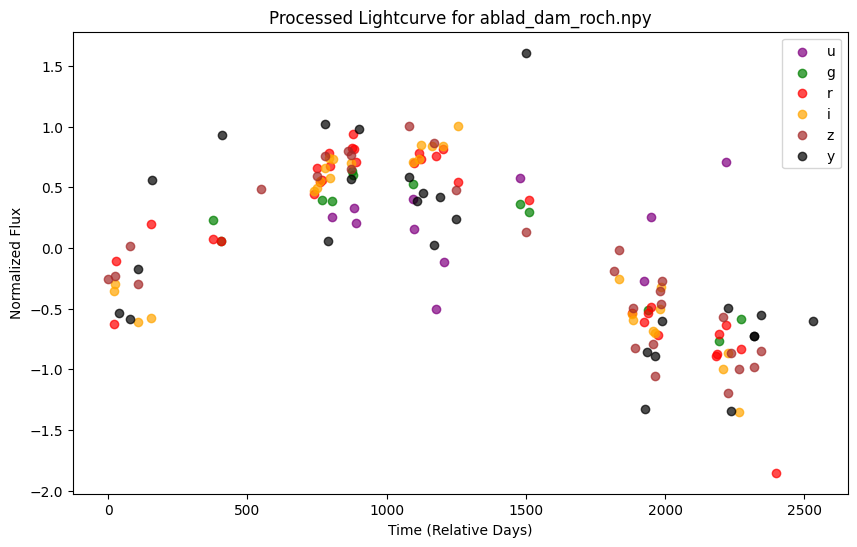

In [19]:
import matplotlib.pyplot as plt

# Đường dẫn file vừa tạo (thử lấy đại một file trong tập train)
# Lưu ý: Bạn cần thay 'obj_id_nao_do.npy' bằng tên một file thực tế trong thư mục processed/train
# Cách đơn giản nhất để lấy 1 file mẫu:
processed_dir = "D:/MALLORN-Astronomical-Classification-Challenge/data/processed/train"
sample_file = os.listdir(processed_dir)[0] # Lấy file đầu tiên tìm thấy
file_path = os.path.join(processed_dir, sample_file)

# Load dữ liệu
data = np.load(file_path)

print(f"Checking file: {sample_file}")
print(f"Shape của dữ liệu: {data.shape}")
print("-" * 30)
print("5 dòng dữ liệu đầu tiên (Time, FilterID, Flux_Norm, Err_Norm):")
print(data[:5])

# Vẽ thử biểu đồ để xem dữ liệu có hợp lý không
plt.figure(figsize=(10, 6))
filters = data[:, 1]
flux = data[:, 2]
time = data[:, 0]

colors = {0:'purple', 1:'green', 2:'red', 3:'orange', 4:'brown', 5:'black'}
labels = {0:'u', 1:'g', 2:'r', 3:'i', 4:'z', 5:'y'}

for f_id in range(6):
    mask = filters == f_id
    if np.sum(mask) > 0:
        plt.scatter(time[mask], flux[mask], c=colors[f_id], label=labels[f_id], alpha=0.7)

plt.xlabel("Time (Relative Days)")
plt.ylabel("Normalized Flux")
plt.title(f"Processed Lightcurve for {sample_file}")
plt.legend()
plt.show()